In [1]:
%reload_ext autoreload

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pandas import Timestamp
import pandas as pd
import sys
from datetime import date
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from statistics import mean 


In [4]:
sys.path.append('../lib')
import utils
import preprocessing

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms') % \
                  (method.__name__, (te - ts) * 1000)
        return result
    
    return timed

//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [6]:
# Load in data

PATH = "../data/"
df = pd.read_csv(f'{PATH}cases.csv', low_memory=False, encoding='latin1')

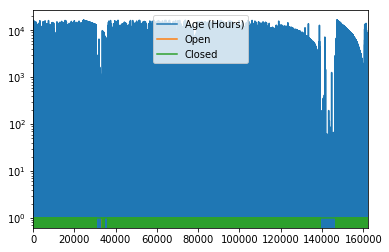

<Figure size 432x288 with 0 Axes>

In [7]:
df.plot()
plt.yscale('log')
plt.show()

plt.savefig('test.png')

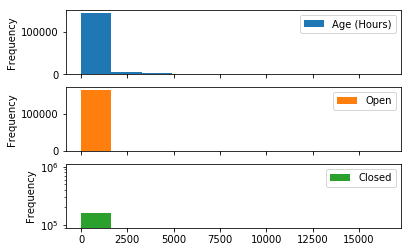

<Figure size 432x288 with 0 Axes>

In [8]:
df.plot(kind='hist',subplots=True)
plt.yscale('log')
plt.show()

plt.savefig('test.png')

//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


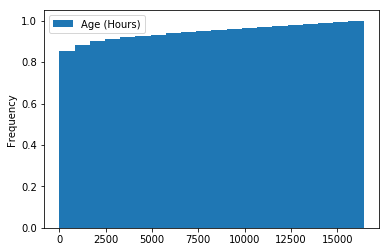

In [9]:
df.plot(y='Age (Hours)', kind='hist', bins=20, cumulative=True, density=True, stacked=True)

In [386]:
df['date'] = df['Date/Time Opened'].str.split(" ", expand = True)[0]
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.drop(columns=['Date/Time Opened'])

,Age (Hours),Open,Closed,Directory ID (web asset),Case Origin,Directory ID,date
0,2.0,0,1,NaN,Email - support@neto.com.au,'-',2018-01-17
1,69.0,0,1,NaN,Child of Parent Case,'-',2018-01-19
2,357.0,0,1,N045335,Phone Inbound - Customer Support,'-',2018-01-31
3,692.0,0,1,N045335,Phone Inbound - Customer Support,'-',2018-01-31
4,17.0,0,1,N045335,Phone Inbound - Customer Support,'-',2018-02-13
...,...,...,...,...,...,...,...
162140,0.0,0,1,N021009,Email - support@neto.com.au,UPCYCLED5421101,2018-07-23
162141,700.0,0,1,N021009,Phone Inbound - Customer Support,UPCYCLED5421101,2018-12-12
162142,4275.0,1,0,N021009,Email - support@neto.com.au,UPCYCLED5421101,2019-05-21
162143,1868.0,0,1,N021009,Proactive Contact,UPCYCLED5421101,2019-08-29


In [392]:
df_aggregate = pd.DataFrame()
unique_n_numbers = df['Directory ID'].unique()
df_aggregate['n_number'] = unique_n_numbers

df['month'] = df['date'].map(lambda x: x.month)
df['year'] = df['date'].map(lambda x: x.year)

#df.set_index('date', inplace = True)

In [394]:
#df.Open.loc[(df['Directory ID'] == 'N001096')].resample('M').mean()

In [ ]:
unique_n_numbers = df['Directory ID'].unique()

In [389]:
unique_years = df.year.unique()

def create_blank_dataframe(unique_year_list):
    rows_list = []
    for n_number in unique_n_numbers:
        for year in unique_years:
            for month in range(1,12):
                dict1 = {
                    'n_number' : n_number,
                    'year' : year,
                    'month' : month,
                    'monthly_total' : 0,
                    'two_month_avg' : 0,
                    'three_month_avg' : 0
                }
                rows_list.append(dict1)
    return pd.DataFrame(rows_list, columns=['n_number', 'year','month', 'monthly_total', 'two_month_avg', 'three_month_avg'])

df_monthly_open = create_blank_dataframe(unique_years)
df_monthly_closed = create_blank_dataframe(unique_years)
df_monthly_age = create_blank_dataframe(unique_years)
df_monthly_origin = create_blank_dataframe(unique_years)

In [390]:
df_monthly_open

,n_number,year,month,monthly_total,two_month_avg,three_month_avg
0,'-',2018,1,0,0,0
1,'-',2018,2,0,0,0
2,'-',2018,3,0,0,0
3,'-',2018,4,0,0,0
4,'-',2018,5,0,0,0
...,...,...,...,...,...,...
140289,WAYNERENTBUY541,2019,7,0,0,0
140290,WAYNERENTBUY541,2019,8,0,0,0
140291,WAYNERENTBUY541,2019,9,0,0,0
140292,WAYNERENTBUY541,2019,10,0,0,0


In [373]:
#df_monthly_open.n_number.unique()[100:200]

# Added a date field
df_monthly_open['date'] = pd.to_datetime(df_monthly_open.assign(day=1).loc[:, ['year','month','day']])


In [374]:
#df_monthly_open.iloc[1].date, df_monthly_open.iloc[1].date + relativedelta(months=-1)

In [375]:
#pd.to_datetime(df['date']).dt.date + relativedelta(months=1)

In [378]:
n_numbers = df_monthly_open.n_number.unique()[100:500]

#@timeit

for n_number in n_numbers:
    for year in [2019]:
        for month in [1]:
            monthly_total = df.Open.loc[(df['Directory ID'] == n_number) &
                                                 (df.year == year) &
                                                 (df.month == month)].sum()
            
            month_ago = df.Open.loc[(df['Directory ID'] == n_number) &
                                    (df['date'] == pd.to_datetime(df['date']).dt.date + relativedelta(months=-1))].sum()
            
            two_months_ago = df.Open.loc[(df['Directory ID'] == n_number) &
                                         (df['date'] == pd.to_datetime(df['date']).dt.date + relativedelta(months=-2))].sum()
            
            df_monthly_open['monthly_total'].loc[(df_monthly_open.n_number == n_number) &
                                                 (df_monthly_open.year == year) &
                                                 (df_monthly_open.month == month)] = monthly_total
            
            df_monthly_open['two_month_avg'].loc[(df_monthly_open.n_number == n_number) &
                                                 (df_monthly_open.year == year) &
                                                 (df_monthly_open.month == month)] = mean([monthly_total, month_ago])
            
            df_monthly_open['three_month_avg'].loc[(df_monthly_open.n_number == n_number) &
                                                   (df_monthly_open.year == year) &
                                                   (df_monthly_open.month == month)] = mean([monthly_total, month_ago, two_months_ago])
            
            
            
            

In [379]:
df_monthly_open.loc[df_monthly_open.monthly_total > 0]

,n_number,year,month,monthly_total,two_month_avg,three_month_avg,date
2277,N001021,2019,1,1,0,0,2019-01-01
2431,N001030,2019,1,2,1,0,2019-01-01
3047,N001096,2019,1,1,0,0,2019-01-01
4411,N001462,2019,1,2,1,0,2019-01-01
4763,N001682,2019,1,1,0,0,2019-01-01
5907,N002627,2019,1,1,0,0,2019-01-01
6787,N004252,2019,1,2,1,0,2019-01-01
7029,N004413,2019,1,1,0,0,2019-01-01
7909,N005035,2019,1,1,0,0,2019-01-01
9493,N005871,2019,1,4,2,1,2019-01-01


In [145]:
# All time stats

df_aggregate = pd.DataFrame()

df_aggregate['n_number'] = unique_n_numbers
df_aggregate['open'] = 0
df_aggregate['closed'] = 0

aggregate_fields = ['open', 'closed']

for n_number in unique_n_numbers:
    for aggregate_field in aggregate_fields:
        field_sum = df.Open.loc[(df['Directory ID'] == n_number)].sum()
        df_aggregate[aggregate_field].loc[df_aggregate['n_number'] == n_number] = field_sum